#**Read data and split it**

In [1]:
import pandas as pd
from datasets import Dataset

df = pd.read_csv("/content/price_cleaned_file.csv")

df = df.rename(columns={"cleaned_comments": "text", "score": "label"})

dataset = Dataset.from_pandas(df)

dataset = dataset.train_test_split(test_size=0.2, seed=42)


In [10]:
df.head()

,comments,text,label
0,The sound quality is great and they work well ...,the sound quality is great and they work well ...,0
1,The material is very disappointing.,the material is very disappointing,0
2,The price is ridiculous for such a low-quality...,the price is ridiculous for such a lowquality ...,-1
3,The price is excellent for something that work...,the price is excellent for something that work...,1
4,This works great and fits great and would defi...,this works great and fits great and would defi...,0


# **Use tokenizer of roberta**

In [2]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/6373 [00:00<?, ? examples/s]

Map:   0%|          | 0/1594 [00:00<?, ? examples/s]

# **add label +1**

In [3]:
from transformers import RobertaForSequenceClassification


label2id = {-1: 0, 0: 1, 1: 2}
id2label = {0: -1, 1: 0, 2: 1}

def convert_labels(example):
    example["label"] = label2id[example["label"]]
    return example

tokenized_dataset = tokenized_dataset.map(convert_labels)

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)


Map:   0%|          | 0/6373 [00:00<?, ? examples/s]

Map:   0%|          | 0/1594 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Train model**

In [7]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.258500,0.164084,0.965496,0.965744,0.965496,0.965476
2,0.042300,0.178868,0.967378,0.967957,0.967378,0.967373
3,0.193100,0.171751,0.964868,0.965653,0.964868,0.964881
4,0.026200,0.213579,0.961731,0.962451,0.961731,0.961816
5,0.018400,0.182879,0.969260,0.970245,0.969260,0.969379
6,0.013000,0.191060,0.966123,0.966991,0.966123,0.966179
7,0.137400,0.251859,0.966123,0.966540,0.966123,0.966159
8,0.036400,0.257209,0.964241,0.964979,0.964241,0.964345
9,0.000300,0.257386,0.964241,0.964894,0.964241,0.964326
10,0.023400,0.260162,0.963614,0.964361,0.963614,0.963693


TrainOutput(global_step=3990, training_loss=0.06330683795084015, metrics={'train_runtime': 1604.4748, 'train_samples_per_second': 39.72, 'train_steps_per_second': 2.487, 'total_flos': 4192054527951360.0, 'train_loss': 0.06330683795084015, 'epoch': 10.0})

# **Evaluation of model**

In [8]:
import numpy as np
from sklearn.metrics import classification_report

preds = trainer.predict(tokenized_dataset["test"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = tokenized_dataset["test"]["label"]

print(classification_report(y_true, y_pred, target_names=["Negative(-1)", "not mentioned(0)", "Positive(1)"]))


                  precision    recall  f1-score   support

    Negative(-1)       0.97      0.98      0.98       568
not mentioned(0)       0.99      0.95      0.97       696
     Positive(1)       0.93      0.98      0.95       330

        accuracy                           0.97      1594
       macro avg       0.96      0.97      0.97      1594
    weighted avg       0.97      0.97      0.97      1594



# **Confusion Matrix**

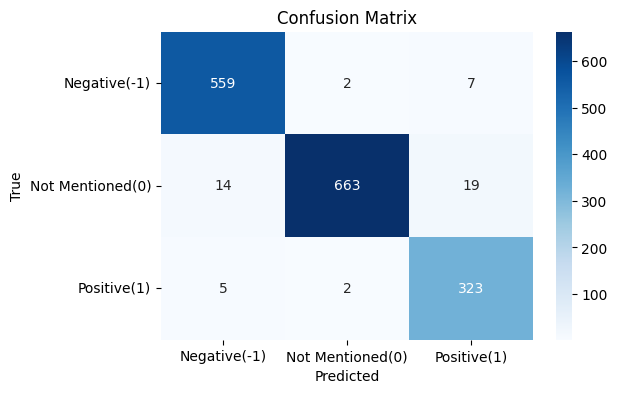

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)


labels = ["Negative(-1)", "Not Mentioned(0)", "Positive(1)"]


plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
